# Manipulación de datos ERA5

La manipulación de datos ERA5 es un paso fundamental en los estudios climáticos y meteorológicos. ERA5 es el conjunto de reanálisis más reciente del Centro Europeo de Predicción Meteorológica a Medio Plazo (ECMWF), que proporciona estimaciones horarias de una amplia gama de variables atmosféricas, terrestres y oceánicas desde 1950 hasta la actualidad.

Este proceso incluye tareas como:

- **Lectura y carga de archivos NetCDF**  
  Utilizando bibliotecas como `xarray` o `netCDF4` para abrir, explorar y extraer variables específicas de los datos.

- **Selección temporal y espacial**  
  Filtrado de períodos de interés (por ejemplo, temporadas específicas o eventos extremos) y recorte espacial de regiones específicas.

- **Conversión de unidades y variables derivadas**  
  Transformación de variables como temperatura en Kelvin a grados Celsius, cálculo de índices climáticos o generación de nuevas variables a partir de las existentes.

- **Reamostrado y agregación temporal**  
  Cambio de resolución temporal (por ejemplo, de datos horarios a diarios o mensuales) para análisis climatológicos.

- **Visualización de datos**  
  Creación de mapas, series temporales y otros gráficos con `matplotlib`, `cartopy` o `holoviews` para facilitar la interpretación de los resultados.

Este flujo de trabajo permite analizar tendencias, evaluar eventos extremos y alimentar modelos numéricos o estadísticos en diversas aplicaciones relacionadas con la atmósfera, el océano y la criosfera.


## Importar librerias

In [47]:
import xarray as xr
import pandas as pd
from scipy.stats import linregress
import matplotlib.pyplot as plt
import numpy as np

## Leer datos `ERA5`

In [48]:
# Definimos la ruta del archivo NetCDF correspondiente al año 2016
filename = '../data/ERA5/ERA5_2016_T2_CB.nc'

# Abrimos el archivo NetCDF de 2016 como un dataset de xarray
ds1 = xr.open_dataset(filename)

# Definimos la ruta del archivo NetCDF correspondiente al año 2017
filename = '../data/ERA5/ERA5_2017_T2_CB.nc'

# Abrimos el archivo NetCDF de 2017 como un dataset de xarray
ds2 = xr.open_dataset(filename)

# Combinamos ambos datasets (2016 y 2017) en uno solo a lo largo de dimensiones comunes (por ejemplo, tiempo)
ds = xr.merge([ds1, ds2])

ds

<xarray.Dataset> Size: 2MB
Dimensions:     (valid_time: 17544, latitude: 7, longitude: 4)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 140kB 2016-01-01 ... 2017-12-31T2...
  * latitude    (latitude) float64 56B -8.5 -8.75 -9.0 -9.25 -9.5 -9.75 -10.0
  * longitude   (longitude) float64 32B -77.85 -77.6 -77.35 -77.1
    number      int64 8B 0
    expver      (valid_time) object 140kB '0001' '0001' '0001' ... '0001' '0001'
Data variables:
    t2m         (valid_time, latitude, longitude) float32 2MB 284.2 ... 277.6
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-06-13T20:16 GRIB to CDM+CF via cfgrib-0.9.1...

## Visulizar para el T1

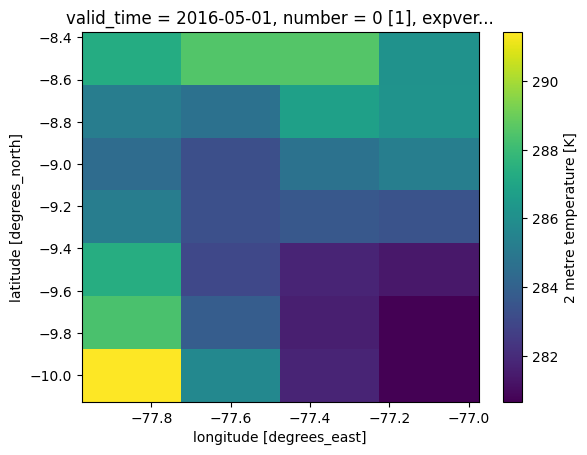

In [49]:
ds.sel(valid_time='2016-05-01T00').t2m.plot()

## Selecionar para una grilla

In [50]:
# Seleccionamos el punto más cercano a las coordenadas geográficas de interés (longitud -77.62, latitud -8.96)
# dentro del dataset 'ds', utilizando el método 'nearest' para encontrar la celda de malla más próxima.
# El resultado se guarda en 'ds_arteson', que representa la serie temporal de ese punto específico.
ds_arteson = ds.sel(longitude=-77.62, latitude=-8.96, method='nearest')
ds_arteson

<xarray.Dataset> Size: 351kB
Dimensions:     (valid_time: 17544)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 140kB 2016-01-01 ... 2017-12-31T2...
    latitude    float64 8B -9.0
    longitude   float64 8B -77.6
    number      int64 8B 0
    expver      (valid_time) object 140kB '0001' '0001' '0001' ... '0001' '0001'
Data variables:
    t2m         (valid_time) float32 70kB 281.6 281.2 280.8 ... 281.6 280.7
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-06-13T20:16 GRIB to CDM+CF via cfgrib-0.9.1...

## Convertir a `dataframe` y horario local

In [51]:
# Convertimos el dataset xarray 'ds_arteson' a un DataFrame de pandas y extraemos solo la columna 't2m' (temperatura a 2 metros)
T2_df = ds_arteson.to_dataframe()[['t2m']]

# Localizamos el índice temporal del DataFrame como UTC (Tiempo Universal Coordinado)
T2_df['data_hora_utc'] = T2_df.index.tz_localize('UTC')

# Convertimos la hora de UTC a la zona horaria de Lima (America/Lima, UTC-5)
T2_df['data_hora_lima'] = T2_df['data_hora_utc'].dt.tz_convert('America/Lima')

# Eliminamos la información de la zona horaria, dejando solo la fecha y hora "naive" (sin offset de zona horaria)
T2_df['fecha_hora'] = T2_df['data_hora_lima'].dt.tz_localize(None)

# Restablecemos el índice del DataFrame como columna normal y seleccionamos solo 'fecha_hora' y 't2m'
T2_df = T2_df.reset_index(drop=False)[['fecha_hora', 't2m']]

# Convertimos la temperatura de Kelvin a grados Celsius
T2_df['t2m'] = T2_df['t2m'] - 273.15
T2_df


,fecha_hora,t2m
0,2015-12-31 19:00:00,8.453766
1,2015-12-31 20:00:00,8.005280
2,2015-12-31 21:00:00,7.682037
3,2015-12-31 22:00:00,7.515289
4,2015-12-31 23:00:00,7.053375
...,...,...
17539,2017-12-31 14:00:00,9.982574
17540,2017-12-31 15:00:00,10.353424
17541,2017-12-31 16:00:00,10.360992
17542,2017-12-31 17:00:00,8.464752


## Leer datos observados

In [52]:
# Definimos la ruta del archivo CSV que contiene los datos de la estación meteorológica automática (AWS)
filename = '../data/AWSs_data_arteson.csv'

# Leemos el archivo CSV usando pandas y lo almacenamos en el DataFrame llamado 'AWS'
AWS = pd.read_csv(filename)

# Convertimos la columna 'fecha_hora' a objetos datetime de pandas para facilitar operaciones temporales
AWS['fecha_hora'] = pd.to_datetime(AWS['fecha_hora'])
AWS

,fecha_hora,Ta_Avg_G,Ta_Avg_M
0,2016-06-01 00:00:00,-0.356606,1.113636
1,2016-06-01 01:00:00,-0.803753,0.589906
2,2016-06-01 02:00:00,-1.104493,0.103807
3,2016-06-01 03:00:00,-1.351831,0.156244
4,2016-06-01 04:00:00,-1.227747,0.214754
...,...,...,...
14435,2018-01-23 11:00:00,2.016000,2.589166
14436,2018-01-23 12:00:00,2.846000,3.048399
14437,2018-01-23 13:00:00,3.244000,3.979526
14438,2018-01-23 14:00:00,3.472000,4.468320


## Juntar datos ERA5 y observados

In [53]:
# Realizamos un merge (fusión) entre los DataFrames T2_df (ERA5) y AWS (observaciones),
# usando la columna 'fecha_hora' como clave de unión. 
# La opción 'how="left"' asegura que se mantengan todas las filas de T2_df,
# agregando los datos de AWS solo donde haya coincidencias de fecha y hora.
T2_ERA5_AWS = pd.merge(T2_df, AWS, on='fecha_hora', how='left')

# Renombramos las columnas del DataFrame resultante para mayor claridad:
# 't2m' pasa a llamarse 'ERA5', 'Ta_Avg_G' a 'OBS_G' (sensor en garita) y 'Ta_Avg_M' a 'OBS_M' (sensor móvil o mastil)
T2_ERA5_AWS = T2_ERA5_AWS.rename(columns={'t2m':'ERA5', 'Ta_Avg_G':'OBS_G', 'Ta_Avg_M':'OBS_M'})
T2_ERA5_AWS

,fecha_hora,ERA5,OBS_G,OBS_M
0,2015-12-31 19:00:00,8.453766,NaN,NaN
1,2015-12-31 20:00:00,8.005280,NaN,NaN
2,2015-12-31 21:00:00,7.682037,NaN,NaN
3,2015-12-31 22:00:00,7.515289,NaN,NaN
4,2015-12-31 23:00:00,7.053375,NaN,NaN
...,...,...,...,...
17539,2017-12-31 14:00:00,9.982574,1.8580,1.623980
17540,2017-12-31 15:00:00,10.353424,0.9160,1.250395
17541,2017-12-31 16:00:00,10.360992,0.4810,1.133617
17542,2017-12-31 17:00:00,8.464752,0.5170,0.988816


## Visualización

<Axes: >

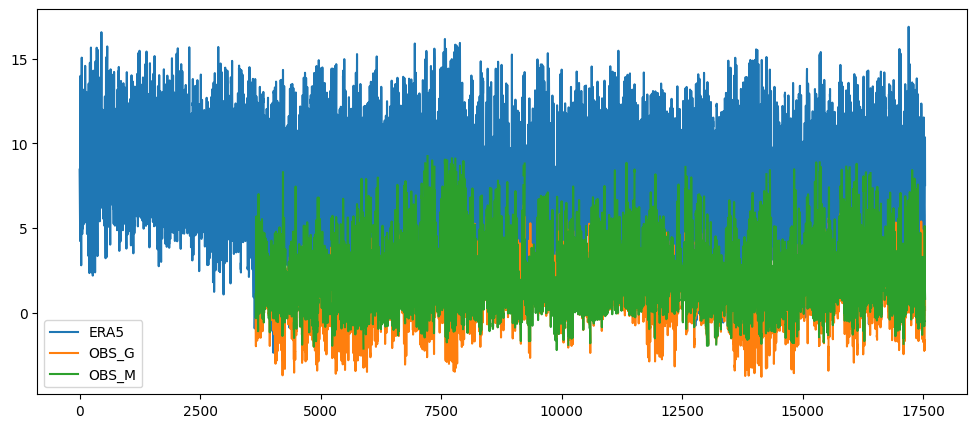

In [54]:
# Selecionamos las series de ERA5, OBS_G y OBS_M
T2_ERA5_AWS[['ERA5', 'OBS_G', 'OBS_M']].plot(figsize=(12, 5))

## Correlación

In [55]:
# Calculamos la matriz de correlación de Pearson entre las columnas 'ERA5', 'OBS_G' y 'OBS_M'
# Esto permite evaluar el grado de asociación lineal entre las temperaturas del reanálisis ERA5
# y las observadas por los sensores de la estación (garita y mástil).
T2_ERA5_AWS[['ERA5', 'OBS_G', 'OBS_M']].corr()

,ERA5,OBS_G,OBS_M
ERA5,1.000000,0.80062,0.807214
OBS_G,0.800620,1.00000,0.897710
OBS_M,0.807214,0.89771,1.000000


## Cargando datos de topografia ERA5

In [56]:
# Definimos la ruta del archivo NetCDF que contiene datos del ERA5 para el año 2017,
# específicamente una variable relacionada con altura ('H'), geopotencial.
filename = '../data/ERA5/ERA5_2017_H_CB.nc'

# Abrimos el archivo NetCDF utilizando xarray y lo almacenamos en el objeto 'DEM'.
# Aunque el nombre de la variable es 'DEM', que representa el geopotencial (Z) o altura geopotencial,
# que puede ser convertido a metros si se divide por la gravedad (9.80665).
DEM = xr.open_dataset(filename)
DEM

<xarray.Dataset> Size: 232B
Dimensions:     (valid_time: 1, latitude: 7, longitude: 4)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 8B 2017-01-01
  * latitude    (latitude) float64 56B -8.5 -8.75 -9.0 -9.25 -9.5 -9.75 -10.0
  * longitude   (longitude) float64 32B -77.85 -77.6 -77.35 -77.1
    expver      <U4 16B ...
Data variables:
    z           (valid_time, latitude, longitude) float32 112B ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-06-13T22:03 GRIB to CDM+CF via cfgrib-0.9.1...

<xarray.DataArray 'z' ()> Size: 8B
array(4303.22412109)
Coordinates:
    number   int64 8B ...
    expver   <U4 16B ...


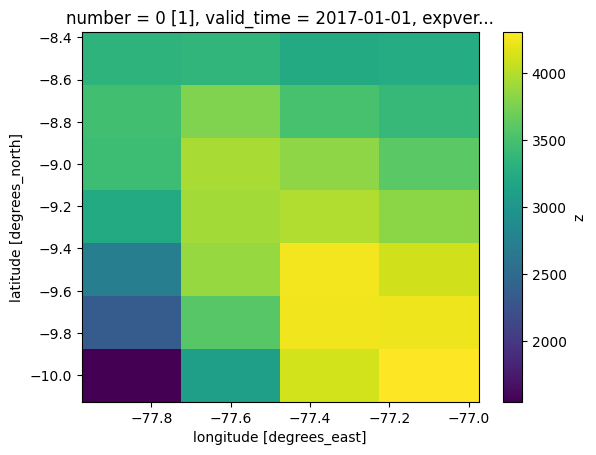

In [57]:
# Dividimos la variable 'z' del dataset 'DEM' por 9.81 para convertir el geopotencial (en m²/s²)
# a metros de altura (z / g), donde g = 9.81 m/s² es la aceleración gravitacional promedio.
# Luego, graficamos el campo resultante como un mapa espacial usando .plot()
(DEM.z / 9.81).plot()

# Calculamos y mostramos en pantalla el valor máximo del campo de altura (en metros)
# Esto permite identificar el punto de mayor elevación en el dominio.
print((DEM.z / 9.81).max())


In [58]:
# Seleccionamos del dataset 'DEM' el punto más cercano a las coordenadas geográficas
# longitud -77.62 y latitud -8.96, usando el método 'nearest' para encontrar la celda más próxima.
H_arteson = DEM.sel(longitude=-77.62, latitude=-8.96, method='nearest')

# Calculamos la altura en metros dividiendo la variable 'z' (geopotencial en m²/s²) por 9.81 m/s² (gravedad).
H_arteson.z / 9.81


<xarray.DataArray 'z' (valid_time: 1)> Size: 4B
array([3948.352], dtype=float32)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 8B 2017-01-01
    latitude    float64 8B -9.0
    longitude   float64 8B -77.6
    expver      <U4 16B ...

## Técnicas de escalamiento

### Regresión lineal

In [59]:
# Seleccionamos solo las columnas 'OBS_G' (observaciones en garita) y 'ERA5' del DataFrame 'T2_ERA5_AWS',
# y eliminamos todas las filas que contienen valores faltantes (NaN) en alguna de estas columnas.
T2_nodata = T2_ERA5_AWS[['OBS_G', 'ERA5']].dropna()

# Mostramos el DataFrame resultante, que contiene únicamente filas con datos completos en ambas columnas.
T2_nodata


,OBS_G,ERA5
3653,-0.356606,5.204987
3654,-0.803753,4.675446
3655,-1.104493,3.815582
3656,-1.351831,3.332184
3657,-1.227747,2.789459
...,...,...
17539,1.858000,9.982574
17540,0.916000,10.353424
17541,0.481000,10.360992
17542,0.517000,8.464752


In [60]:
# Definimos las variables x e y
x = T2_nodata['ERA5']
y = T2_nodata['OBS_G']

In [61]:
# Calcular regresión lineal
pendiente, intercepto, r_value, p_value, std_err = linregress(x, y)
print(pendiente, intercepto, r_value, p_value, std_err)

0.38223578684275794 -1.466515302942202 0.800620463206841 0.0 0.0024315768293897947


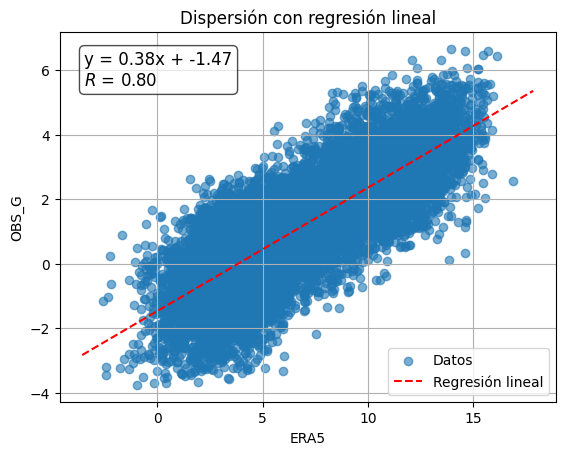

In [62]:
# Crear el gráfico de dispersión
fig, ax = plt.subplots()
ax.scatter(x, y, alpha=0.6, label='Datos')

# Dibujar línea de regresión
x_vals = np.array(ax.get_xlim())
y_vals = intercepto + pendiente * x_vals
ax.plot(x_vals, y_vals, color='red', linestyle='--', label='Regresión lineal')

# Añadir ecuación y R al gráfico
texto_ecuacion = f'y = {pendiente:.2f}x + {intercepto:.2f}\n$R$ = {r_value:.2f}'
ax.text(0.05, 0.95, texto_ecuacion, transform=ax.transAxes,
        fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

# Etiquetas y estilo
ax.set_xlabel('ERA5')
ax.set_ylabel('OBS_G')
ax.set_title('Dispersión con regresión lineal')
ax.legend()
plt.grid(True)
plt.show()

In [63]:
# Rellenar los valores faltantes en Ta_Avg_x usando la ecuación de regresión
T2_ERA5_AWS['ERA5_corr'] = (pendiente * T2_ERA5_AWS['ERA5'] + intercepto)

<Axes: >

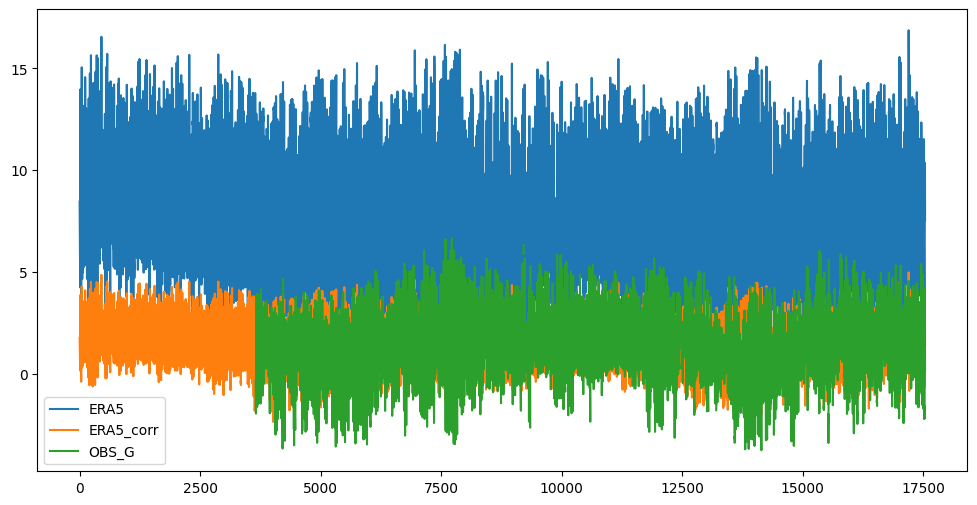

In [64]:
# Visualizando
T2_ERA5_AWS[['ERA5', 'ERA5_corr', 'OBS_G']].plot(figsize=(12,6))

In [65]:
# Correlación
T2_ERA5_AWS[['ERA5', 'ERA5_corr', 'OBS_G']].corr()

,ERA5,ERA5_corr,OBS_G
ERA5,1.00000,1.00000,0.80062
ERA5_corr,1.00000,1.00000,0.80062
OBS_G,0.80062,0.80062,1.00000


### Usando un grandiente de temperatura altitudinal

In [71]:
# Definimos la tasa de gradiente adiabático ambiental para la temperatura a 2 metros,
# es decir, la tasa de cambio de temperatura con la altura, con valor -0.65 ºC por cada 100 metros.
lapse_rate_T2 = -0.65 / 100  # (ºC/m)

# Altura de la estación meteorológica automática (AWS) en metros sobre el nivel del mar
hgt_aws = 4870

# Altura estimada del punto ERA5 en metros, calculada dividiendo el geopotencial (en m²/s²)
# por la gravedad estándar (9.81 m/s²)
hgt_era = (H_arteson.z.values / 9.81)

hgt_era

array([3948.352], dtype=float32)

In [ ]:
# Calculamos una temperatura corregida para la variable 'ERA5' ajustando por la diferencia de altura
# entre la estación AWS (hgt_aws) y el punto ERA5 (hgt_era), usando la tasa de gradiente térmico (lapse_rate_T2).
# Esta corrección aplica la fórmula del gradiente adiabático para estimar la temperatura equivalente a la altura de la AWS.
T2_ERA5_AWS['ERA5_corr_lr'] = T2_ERA5_AWS['ERA5'] + (hgt_aws - hgt_era) * lapse_rate_T2


<Axes: xlabel='fecha_hora'>

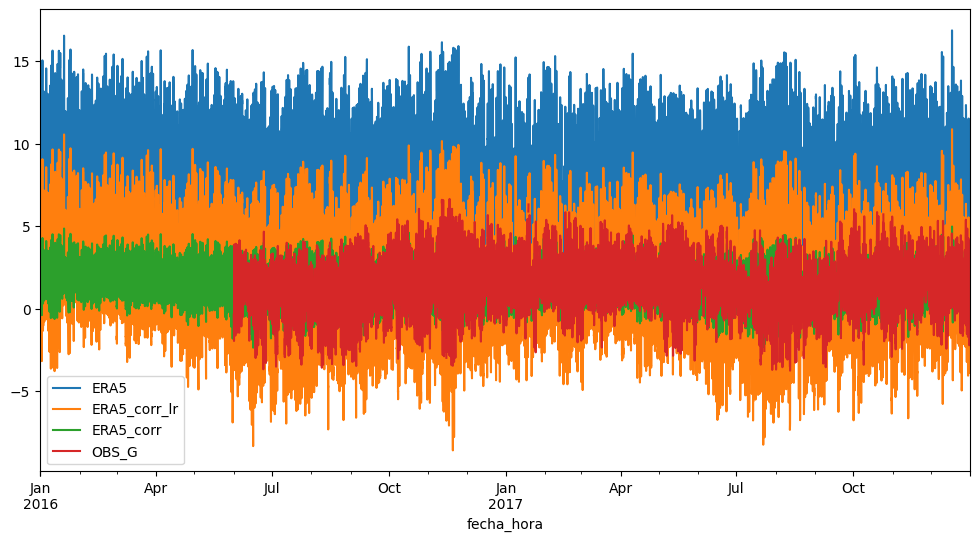

In [72]:
# Visualizamos
T2_ERA5_AWS[['ERA5', 'ERA5_corr_lr', 'ERA5_corr', 'OBS_G']].plot(figsize=(12,6))

## Redefinimos el index

In [73]:
# Establecemos la columna 'fecha_hora' como índice del DataFrame 'T2_ERA5_AWS',
# lo que facilita operaciones basadas en tiempo, como selección por fechas o resampling.
T2_ERA5_AWS.index = T2_ERA5_AWS.fecha_hora
T2_ERA5_AWS

,fecha_hora,ERA5,OBS_G,OBS_M,ERA5_corr,ERA5_corr_lr
fecha_hora,,,,,,
2015-12-31 19:00:00,2015-12-31 19:00:00,8.453766,NaN,NaN,1.764817,2.463054
2015-12-31 20:00:00,2015-12-31 20:00:00,8.005280,NaN,NaN,1.593389,2.014568
2015-12-31 21:00:00,2015-12-31 21:00:00,7.682037,NaN,NaN,1.469834,1.691326
2015-12-31 22:00:00,2015-12-31 22:00:00,7.515289,NaN,NaN,1.406097,1.524578
2015-12-31 23:00:00,2015-12-31 23:00:00,7.053375,NaN,NaN,1.229537,1.062664
...,...,...,...,...,...,...
2017-12-31 14:00:00,2017-12-31 14:00:00,9.982574,1.8580,1.623980,2.349182,3.991863
2017-12-31 15:00:00,2017-12-31 15:00:00,10.353424,0.9160,1.250395,2.490934,4.362712
2017-12-31 16:00:00,2017-12-31 16:00:00,10.360992,0.4810,1.133617,2.493827,4.370281


<Axes: xlabel='fecha_hora'>

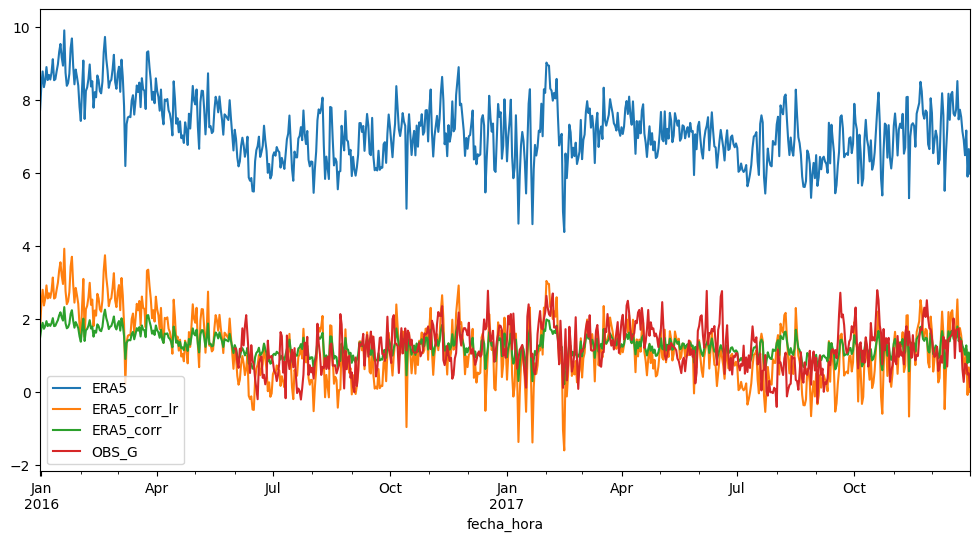

In [74]:
# Seleccionamos las columnas 'ERA5', 'ERA5_corr_lr', 'ERA5_corr' y 'OBS_G' del DataFrame 'T2_ERA5_AWS'.
# Aplicamos un re-muestreo temporal diario ('1d') y calculamos la media de cada día para suavizar los datos horarios.
# Finalmente, graficamos las series temporales resultantes en una figura de tamaño 12x6 pulgadas.
T2_ERA5_AWS[['ERA5', 'ERA5_corr_lr', 'ERA5_corr', 'OBS_G']].resample('1d').mean().plot(figsize=(12,6))